In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pylab as plt
import glob
import os
from pprint import pprint
import scipy.integrate as inte
import scipy.special as special
import scipy.interpolate as interp
import scipy.signal as sig

In [3]:
import stephane.display.graphes as graphes
import stephane.tools.Smath as smath

import icewave.tools.datafolders as df
import icewave.tools.rw_data as rw_data

#import sympy #symoblic python
#import mpmath as math
#import cv2
import glob
import csv
import os

import icewave.phone.rw_pyphone as rw
import icewave.field.multi_instruments as multi

Linux
oural
Please install garmin package
Linux

/media/turbots/


In [129]:
savefolder = '/home/turbots/Documents/Bicwin2024/git/phonefleet/phonefleet/Bic25/Tsync/' 

In [5]:
import urllib
import phonefleet.connect as connect

In [10]:
phonelist = connect.scan()

['Starting Nmap 7.80 ( https://nmap.org ) at 2025-01-21 20:19 CET',
 'Nmap scan report for _gateway (192.168.2.1)',
 'Host is up (0.0033s latency).',
 'Nmap scan report for oural (192.168.2.11)',
 'Host is up (0.00013s latency).',
 'Nmap scan report for 192.168.2.100',
 'Host is up (0.096s latency).',
 'Nmap scan report for 192.168.2.101',
 'Host is up (0.098s latency).',
 'Nmap scan report for 192.168.2.103',
 'Host is up (0.096s latency).',
 'Nmap scan report for 192.168.2.104',
 'Host is up (0.096s latency).',
 'Nmap scan report for 192.168.2.105',
 'Host is up (0.060s latency).',
 'Nmap done: 256 IP addresses (7 hosts up) scanned in 3.70 seconds',
 '']
Host is up, Nmap scan report for _gateway (192.168.2.1)
1)
format does not correspond to a phone
Host is up, Nmap scan report for oural (192.168.2.11)
11)
format does not correspond to a phone
Host is up, Nmap scan report for 192.168.2.100
100
Host is up, Nmap scan report for 192.168.2.101
101
Host is up, Nmap scan report for 192.168

In [11]:
phonelist

[0, 1, 3, 4, 5]

In [14]:
import phonefleet.run_gobannos as gob
for phone in phonelist:
    ip = connect.get_adress(phone)
    status = gob.get_status(ip)
    print(status)
    if not status==b'STOPPED':
        gob.individual_stop(ip)

http://192.168.2.100:8080/status
Status :b'STOPPED'
b'STOPPED'
http://192.168.2.101:8080/status
Status :b'UDP CALIB FINISHED'
b'UDP CALIB FINISHED'
http://192.168.2.103:8080/status
Status :b'STOPPED'
b'STOPPED'
http://192.168.2.104:8080/status
Status :b'STOPPED'
b'STOPPED'
http://192.168.2.105:8080/status
Status :b'STOPPED'
b'STOPPED'


In [4]:
# bad idea to test udp sync in a jupyter notebook
from pprint import pprint
Dt1 = {0: 1737224611070.1577, 1: 1737224614306.5278, 3: 1737224618056.6975, 4: 1737224622603.7207, 5: 1737224626371.2207}
Dt2 = {0: 1737224611069.1682, 1: 1737224614308.81, 3: 1737224618056.6807, 4: 1737224622603.712, 5: 1737224626373.4565}
Dt3 = {0: 1737224611069.133, 1: 1737224614306.452, 3: 1737224618056.664, 4: 1737224622603.7566, 5: 1737224626371.2625}

pprint(Dt1)
pprint(Dt2)
pprint(Dt3)

{0: 1737224611070.1577,
 1: 1737224614306.5278,
 3: 1737224618056.6975,
 4: 1737224622603.7207,
 5: 1737224626371.2207}
{0: 1737224611069.1682,
 1: 1737224614308.81,
 3: 1737224618056.6807,
 4: 1737224622603.712,
 5: 1737224626373.4565}
{0: 1737224611069.133,
 1: 1737224614306.452,
 3: 1737224618056.664,
 4: 1737224622603.7566,
 5: 1737224626371.2625}


In [27]:
import socket

In [28]:
socket.settimeout(1)

AttributeError: module 'socket' has no attribute 'settimeout'

In [107]:
Dts = {0: [1737224611.067247, 1737224611.0672734, 1737224611.0672717, 1737224611.0671868, 1737224611.0672417, 1737224611.0672226, 1737224611.067288, 1737224611.0672812, 1737224611.0673087, 1737224611.067298, 1737224611.0672908, 1737224611.0673594, 1737224611.0673242, 1737224611.0673342, 1737224611.0673642, 1737224611.0673234, 1737224611.067346, 1737224611.0673661, 1737224611.0673919, 1737224611.0673766, 1737224611.0674, 1737224611.0673132, 1737224611.0674453, 1737224611.0674555, 1737224611.0674329, 1737224611.0674963, 1737224611.0674314, 1737224611.067467], 1: [1737224614.3082614, 1737224614.3083205, 1737224614.3083088, 1737224614.308353, 1737224614.3083596, 1737224614.3083549, 1737224614.308305, 1737224614.3083012, 1737224614.3083348, 1737224614.3084257, 1737224614.3082876, 1737224614.308457, 1737224614.3083239, 1737224614.308337, 1737224614.3083658, 1737224614.3084338, 1737224614.308422, 1737224614.3084512, 1737224614.3084223, 1737224614.3083768, 1737224614.3084407, 1737224614.3084779, 1737224614.308479, 1737224614.3084748, 1737224614.3084857, 1737224614.3084836, 1737224614.3085303, 1737224614.308537], 3: [1737224618.054247, 1737224618.0550456, 1737224618.0544066, 1737224618.054307, 1737224618.0543194, 1737224618.054286, 1737224618.0543456, 1737224618.055132, 1737224618.0542946, 1737224618.0544038, 1737224618.054374, 1737224618.0543451, 1737224618.0543997, 1737224618.054365, 1737224618.0544288, 1737224618.0555973, 1737224618.0544057, 1737224618.0544314, 1737224618.0543804, 1737224618.0544484, 1737224618.054487, 1737224618.0550883, 1737224618.0544965, 1737224618.0545082, 1737224618.054447, 1737224618.0545416, 1737224618.0544896, 1737224618.055778], 4: [1737224622.6011052, 1737224622.6011763, 1737224622.6011295, 1737224622.6011376, 1737224622.6017761, 1737224622.6010594, 1737224622.6010962, 1737224622.602343, 1737224622.6011367, 1737224622.601199, 1737224622.6020784, 1737224622.6011765, 1737224622.601142, 1737224622.6011977, 1737224622.6012893, 1737224622.6012616, 1737224622.6012049, 1737224622.6012511, 1737224622.601256, 1737224622.6012483, 1737224622.6030612, 1737224622.6012306, 1737224622.601278, 1737224622.601307, 1737224622.6013079, 1737224622.6012979, 1737224622.6012878, 1737224622.6020484], 5: [1737224626.3689075, 1737224626.3689694, 1737224626.3689716, 1737224626.3689303, 1737224626.3689742, 1737224626.371073, 1737224626.3689861, 1737224626.3690627, 1737224626.369, 1737224626.3689768, 1737224626.3690028, 1737224626.3690739, 1737224626.3690643, 1737224626.3690307, 1737224626.3692896, 1737224626.3690782, 1737224626.369466, 1737224626.369094, 1737224626.3691, 1737224626.3691216, 1737224626.3690636, 1737224626.3691258, 1737224626.3691368, 1737224626.369176, 1737224626.3691165, 1737224626.3691797, 1737224626.3691528, 1737224626.3691883]}

In [108]:
1737224611.0718873/3600/24/365

55.08703104616588

1737224611.0673406 7.75910153710477e-05
1737224614.3083973 7.67377997902025e-05
1737224618.0545642 0.00038439675846992165
1737224622.601396 0.0004489799394028019
1737224626.369154 0.00038634303326750007


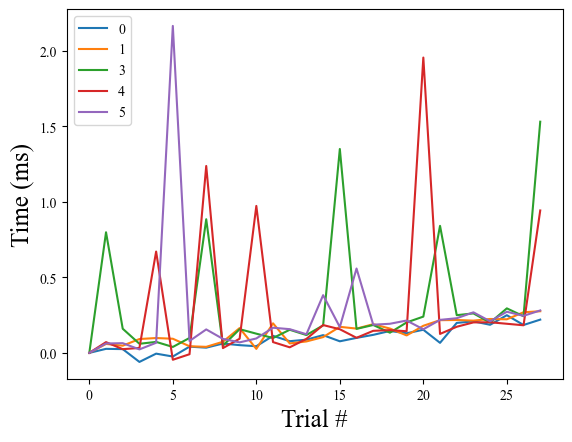

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import icewave.display.graphes as graphes

for phone in Dts.keys():
    print(np.mean(Dts[phone]),np.std(Dts[phone]))
    plt.plot((np.asarray(Dts[phone])-Dts[phone][0])*1000)
    
    figs = graphes.legende('Trial #','Time (ms)','')
    
plt.legend(Dts.keys())

#graphes.save_figs(figs,savedir=savefolder)

In [125]:
Dts2 = {0: [1737224611.0675402, 1737224611.0675802, 1737224611.0675828, 1737224611.0675907, 1737224611.0675762, 1737224611.0675702, 1737224611.067606, 1737224611.0675855, 1737224611.0675395, 1737224611.067656, 1737224611.0676014, 1737224611.0676346, 1737224611.0676556, 1737224611.067535, 1737224611.0676873, 1737224611.0677195, 1737224611.067702, 1737224611.0676532, 1737224611.0677233, 1737224611.0677319, 1737224611.0676806, 1737224611.0677195, 1737224611.0677066, 1737224611.0677013, 1737224611.067658, 1737224611.0676637, 1737224611.0677023, 1737224611.0676942, 1737224611.067711, 1737224611.0677247, 1737224611.0677848, 1737224611.0677743, 1737224611.0677383, 1737224611.067707, 1737224611.0677638, 1737224611.0678606, 1737224611.067854, 1737224611.0679545, 1737224611.06801, 1737224611.0679815, 1737224611.0680573, 1737224611.0680444, 1737224611.0681436, 1737224611.0681477, 1737224611.0681858, 1737224611.0682168, 1737224611.0682945, 1737224611.0683498, 1737224611.0682962, 1737224611.0683742, 1737224611.0685573, 1737224611.0685134, 1737224611.068586, 1737224611.0685368, 1737224611.068612, 1737224611.0686536, 1737224611.0686772, 1737224611.068774, 1737224611.0687177, 1737224611.0687604, 1737224611.0688481, 1737224611.0688267, 1737224611.0688577, 1737224611.0688715, 1737224611.0689454, 1737224611.069008, 1737224611.0689924, 1737224611.06908, 1737224611.0690484, 1737224611.0691457, 1737224611.0691512, 1737224611.0691442, 1737224611.0691426, 1737224611.06924, 1737224611.0693007, 1737224611.0692618, 1737224611.0694363, 1737224611.0693984, 1737224611.0694528, 1737224611.0694294, 1737224611.0694728, 1737224611.0694187, 1737224611.0695128, 1737224611.0695572, 1737224611.0695682, 1737224611.069591, 1737224611.0695984, 1737224611.0696564, 1737224611.0696929, 1737224611.0696707, 1737224611.0697181, 1737224611.069767, 1737224611.0697732, 1737224611.069883, 1737224611.0698667, 1737224611.0698447, 1737224611.0698862, 1737224611.0699153, 1737224611.069851, 1737224611.0699677], 1: [1737224614.308584, 1737224614.3086026, 1737224614.30869, 1737224614.3087034, 1737224614.308662, 1737224614.3086333, 1737224614.3086352, 1737224614.3086052, 1737224614.308674, 1737224614.3086948, 1737224614.3085973, 1737224614.30863, 1737224614.3087184, 1737224614.308701, 1737224614.308737, 1737224614.3087065, 1737224614.3087468, 1737224614.308712, 1737224614.3087845, 1737224614.3087578, 1737224614.3087745, 1737224614.308872, 1737224614.3087435, 1737224614.308748, 1737224614.3087273, 1737224614.3087819, 1737224614.3087745, 1737224614.3088412, 1737224614.3087864, 1737224614.3087792, 1737224614.308852, 1737224614.3087668, 1737224614.3088279, 1737224614.3088982, 1737224614.308888, 1737224614.3089187, 1737224614.3090029, 1737224614.309014, 1737224614.3090384, 1737224614.3090677, 1737224614.3091724, 1737224614.3091717, 1737224614.3158283, 1737224614.3092484, 1737224614.3093402, 1737224614.3093486, 1737224614.3094213, 1737224614.3094716, 1737224614.3093805, 1737224614.3095703, 1737224614.309587, 1737224614.3096578, 1737224614.309606, 1737224614.3096275, 1737224614.3097064, 1737224614.309701, 1737224614.309842, 1737224614.3097987, 1737224614.3098397, 1737224614.3097973, 1737224614.3098717, 1737224614.309939, 1737224614.3100133, 1737224614.3099504, 1737224614.3100715, 1737224614.3099504, 1737224614.31009, 1737224614.310124, 1737224614.3101676, 1737224614.3102703, 1737224614.3102412, 1737224614.3102343, 1737224614.3102975, 1737224614.3103304, 1737224614.310408, 1737224614.3103976, 1737224614.310433, 1737224614.3104563, 1737224614.3104897, 1737224614.3105357, 1737224614.3104641, 1737224614.3105674, 1737224614.3105621, 1737224614.3107457, 1737224614.3107295, 1737224614.310711, 1737224614.3107452, 1737224614.3108168, 1737224614.31083, 1737224614.3108535, 1737224614.3108015, 1737224614.3107963, 1737224614.3109186, 1737224614.310854, 1737224614.3109798, 1737224614.3110027, 1737224614.3109288, 1737224614.310967, 1737224614.311108, 1737224614.3110347], 3: [1737224618.0545726, 1737224618.0546038, 1737224618.054637, 1737224618.054572, 1737224618.0560555, 1737224618.0546772, 1737224618.0546668, 1737224618.0547018, 1737224618.0546093, 1737224618.0560136, 1737224618.0547159, 1737224618.0556254, 1737224618.054716, 1737224618.0547338, 1737224618.0546665, 1737224618.0547674, 1737224618.0547702, 1737224618.0547822, 1737224618.0547647, 1737224618.0559285, 1737224618.05483, 1737224618.054947, 1737224618.0547795, 1737224618.0561757, 1737224618.0547945, 1737224618.0548491, 1737224618.0561767, 1737224618.054774, 1737224618.054861, 1737224618.0547855, 1737224618.0547285, 1737224618.05476, 1737224618.0554423, 1737224618.0559092, 1737224618.0549068, 1737224618.0549347, 1737224618.0564566, 1737224618.0550113, 1737224618.0551074, 1737224618.0550704, 1737224618.0550752, 1737224618.055214, 1737224618.0552213, 1737224618.05527, 1737224618.0553284, 1737224618.055285, 1737224618.0553849, 1737224618.055531, 1737224618.055424, 1737224618.0569289, 1737224618.0556107, 1737224618.0555592, 1737224618.056694, 1737224618.05657, 1737224618.0556834, 1737224618.0556893, 1737224618.0559354, 1737224618.0572505, 1737224618.0557761, 1737224618.0559425, 1737224618.0558906, 1737224618.0560193, 1737224618.055966, 1737224618.055959, 1737224618.055975, 1737224618.0569487, 1737224618.0561304, 1737224618.056155, 1737224618.056188, 1737224618.0561996, 1737224618.0562487, 1737224618.0562696, 1737224618.0571804, 1737224618.056346, 1737224618.0563583, 1737224618.0564508, 1737224618.0563793, 1737224618.0563715, 1737224618.056532, 1737224618.056505, 1737224618.0566967, 1737224618.0565033, 1737224618.0565846, 1737224618.0567412, 1737224618.0565054, 1737224618.056723, 1737224618.0566983, 1737224618.0579283, 1737224618.0568976, 1737224618.0566502, 1737224618.0567412, 1737224618.0573094, 1737224618.0568273, 1737224618.057949, 1737224618.0582178, 1737224618.0568924, 1737224618.0570896, 1737224618.05691, 1737224618.0570116, 1737224618.0569205], 4: [1737224622.6014102, 1737224622.601417, 1737224622.60146, 1737224622.6013997, 1737224622.6014757, 1737224622.601469, 1737224622.6016996, 1737224622.6024246, 1737224622.6014755, 1737224622.601492, 1737224622.603004, 1737224622.6015077, 1737224622.601493, 1737224622.6015384, 1737224622.601519, 1737224622.6015742, 1737224622.6015897, 1737224622.6015968, 1737224622.601646, 1737224622.601595, 1737224622.6015856, 1737224622.601624, 1737224622.6015584, 1737224622.601585, 1737224622.602747, 1737224622.6030693, 1737224622.601583, 1737224622.601502, 1737224622.6016073, 1737224622.6015563, 1737224622.6030765, 1737224622.6016533, 1737224622.602887, 1737224622.6016438, 1737224622.6016872, 1737224622.6029882, 1737224622.6017728, 1737224622.6017296, 1737224622.60191, 1737224622.6021059, 1737224622.602004, 1737224622.6020184, 1737224622.6033382, 1737224622.6020484, 1737224622.6035857, 1737224622.6021585, 1737224622.6022148, 1737224622.6022882, 1737224622.6022916, 1737224622.6022823, 1737224622.6038947, 1737224622.6023993, 1737224622.6024194, 1737224622.6024256, 1737224622.6026936, 1737224622.602619, 1737224622.602577, 1737224622.6026874, 1737224622.602584, 1737224622.602739, 1737224622.6026738, 1737224622.6027322, 1737224622.603663, 1737224622.602779, 1737224622.603609, 1737224622.602888, 1737224622.6028972, 1737224622.6031356, 1737224622.6030052, 1737224622.60392, 1737224622.6030788, 1737224622.6039813, 1737224622.6031232, 1737224622.6031713, 1737224622.6031733, 1737224622.6031961, 1737224622.6031857, 1737224622.6031485, 1737224622.6032777, 1737224622.6032677, 1737224622.6033154, 1737224622.6035514, 1737224622.6053152, 1737224622.6033993, 1737224622.6034508, 1737224622.6042142, 1737224622.603499, 1737224622.6036186, 1737224622.6034484, 1737224622.6035736, 1737224622.60358, 1737224622.603685, 1737224622.6040645, 1737224622.603716, 1737224622.6037364, 1737224622.603787, 1737224622.6037254, 1737224622.603744, 1737224622.6038108, 1737224622.6038613], 5: [1737224626.3692331, 1737224626.3695154, 1737224626.3692358, 1737224626.369334, 1737224626.369288, 1737224626.3692503, 1737224626.3693452, 1737224626.3693607, 1737224626.369317, 1737224626.3693395, 1737224626.3693457, 1737224626.3694503, 1737224626.3693347, 1737224626.3693051, 1737224626.36937, 1737224626.369417, 1737224626.36944, 1737224626.369433, 1737224626.369361, 1737224626.3694777, 1737224626.3694797, 1737224626.3694491, 1737224626.3694038, 1737224626.3694189, 1737224626.3693483, 1737224626.3708165, 1737224626.369436, 1737224626.369502, 1737224626.3694797, 1737224626.3694654, 1737224626.3694243, 1737224626.3708334, 1737224626.3694525, 1737224626.3694882, 1737224626.3694527, 1737224626.369611, 1737224626.3709855, 1737224626.369644, 1737224626.3696828, 1737224626.3698301, 1737224626.3698668, 1737224626.3791537, 1737224626.369875, 1737224626.3699603, 1737224626.369941, 1737224626.3712964, 1737224626.3701296, 1737224626.3703601, 1737224626.3700974, 1737224626.3702297, 1737224626.3701882, 1737224626.3702369, 1737224626.3702493, 1737224626.3702846, 1737224626.3703623, 1737224626.3716702, 1737224626.370397, 1737224626.3709102, 1737224626.3704896, 1737224626.37052, 1737224626.370614, 1737224626.370607, 1737224626.370594, 1737224626.370604, 1737224626.3706226, 1737224626.3707123, 1737224626.370744, 1737224626.3708234, 1737224626.3710997, 1737224626.370853, 1737224626.3709393, 1737224626.372191, 1737224626.370998, 1737224626.3709867, 1737224626.3710256, 1737224626.3710601, 1737224626.3710155, 1737224626.3711698, 1737224626.373161, 1737224626.3711739, 1737224626.3711276, 1737224626.371298, 1737224626.371274, 1737224626.3726883, 1737224626.3713374, 1737224626.3713355, 1737224626.3723564, 1737224626.3713894, 1737224626.3714538, 1737224626.3714328, 1737224626.371448, 1737224626.3716636, 1737224626.3715634, 1737224626.3714643, 1737224626.3715215, 1737224626.3727226, 1737224626.3730981, 1737224626.3715725, 1737224626.371719, 1737224626.3719974]}

In [131]:
import icewave.tools.rw_data as rw

rw.write_csv

1737224611.0685318 0.0008123052972880749
1737224614.3096848 0.0010296360284143204
1737224618.0558312 0.000900797606714722
1737224622.6026292 0.000893189676817949
1737224626.3705304 0.0013103738917071407


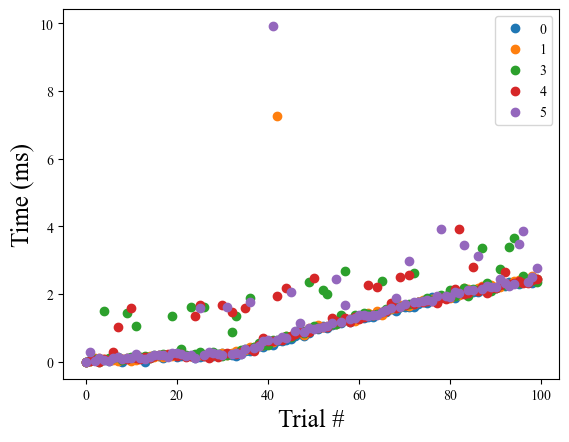

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import icewave.display.graphes as graphes

for phone in Dts.keys():
    print(np.mean(Dts2[phone]),np.std(Dts2[phone]))
    plt.plot((np.asarray(Dts2[phone])-Dts2[phone][0])*1000,'o')
    
    figs = graphes.legende('Trial #','Time (ms)','')
    
plt.legend(Dts.keys())

graphes.save_figs(figs,savedir=savefolder,prefix='Test_tsync_100runs_n50_5phones')

In [132]:
dtsync = {'0_0': {'phone': 0, 'iter': 0, 'tlag': 1737224611.0762172, 'dtmedian': 0.0033971030000000003, 'tmin': 1737224611.0762172, 'tmax': 1737224611.0762172, 'tstd': 0.0, 'n': 50}, '1_0': {'phone': 1, 'iter': 0, 'tlag': 1737224614.3178167, 'dtmedian': 0.003021845, 'tmin': 1737224614.3178167, 'tmax': 1737224614.3178167, 'tstd': 0.0, 'n': 50}, '3_0': {'phone': 3, 'iter': 0, 'tlag': 1737224618.0631132, 'dtmedian': 0.0030868230000000003, 'tmin': 1737224618.0631132, 'tmax': 1737224618.0631132, 'tstd': 0.0, 'n': 50}, '4_0': {'phone': 4, 'iter': 0, 'tlag': 1737224622.609877, 'dtmedian': 0.0033793235000000002, 'tmin': 1737224622.609877, 'tmax': 1737224622.609877, 'tstd': 0.0, 'n': 50}, '5_0': {'phone': 5, 'iter': 0, 'tlag': 1737224626.3778405, 'dtmedian': 0.002912497, 'tmin': 1737224626.3778405, 'tmax': 1737224626.3778405, 'tstd': 0.0, 'n': 50}, '0_1': {'phone': 0, 'iter': 1, 'tlag': 1737224611.0761762, 'dtmedian': 0.0028822265, 'tmin': 1737224611.0761762, 'tmax': 1737224611.0761762, 'tstd': 0.0, 'n': 50}, '1_1': {'phone': 1, 'iter': 1, 'tlag': 1737224614.3178298, 'dtmedian': 0.0027922155000000004, 'tmin': 1737224614.3178298, 'tmax': 1737224614.3178298, 'tstd': 0.0, 'n': 50}, '3_1': {'phone': 3, 'iter': 1, 'tlag': 1737224618.064404, 'dtmedian': 0.001869081, 'tmin': 1737224618.064404, 'tmax': 1737224618.064404, 'tstd': 0.0, 'n': 49}, '4_1': {'phone': 4, 'iter': 1, 'tlag': 1737224622.6098893, 'dtmedian': 0.003080928, 'tmin': 1737224622.6098893, 'tmax': 1737224622.6098893, 'tstd': 0.0, 'n': 50}, '5_1': {'phone': 5, 'iter': 1, 'tlag': 1737224626.3778505, 'dtmedian': 0.0030326855, 'tmin': 1737224626.3778505, 'tmax': 1737224626.3778505, 'tstd': 0.0, 'n': 50}}


pprint(dtsync)

{'0_0': {'dtmedian': 0.0033971030000000003,
         'iter': 0,
         'n': 50,
         'phone': 0,
         'tlag': 1737224611.0762172,
         'tmax': 1737224611.0762172,
         'tmin': 1737224611.0762172,
         'tstd': 0.0},
 '0_1': {'dtmedian': 0.0028822265,
         'iter': 1,
         'n': 50,
         'phone': 0,
         'tlag': 1737224611.0761762,
         'tmax': 1737224611.0761762,
         'tmin': 1737224611.0761762,
         'tstd': 0.0},
 '1_0': {'dtmedian': 0.003021845,
         'iter': 0,
         'n': 50,
         'phone': 1,
         'tlag': 1737224614.3178167,
         'tmax': 1737224614.3178167,
         'tmin': 1737224614.3178167,
         'tstd': 0.0},
 '1_1': {'dtmedian': 0.0027922155000000004,
         'iter': 1,
         'n': 50,
         'phone': 1,
         'tlag': 1737224614.3178298,
         'tmax': 1737224614.3178298,
         'tmin': 1737224614.3178298,
         'tstd': 0.0},
 '3_0': {'dtmedian': 0.0030868230000000003,
         'iter': 0,
       

In [134]:
import time
savefolder = '/home/turbots/Documents/Bicwin2024/git/phonefleet/phonefleet/Bic25/Tsync/' 
filename = savefolder+'tsync_'+str(int(np.round(time.time())))
rw.writedict_csv(filename,dtsync)

['0_0', '1_0', '3_0', '4_0', '5_0', '0_1', '1_1', '3_1', '4_1', '5_1']


In [10]:
import re

datas = {}
for phone in phonelist:
    datas[phone] = {}

    ip = connect.get_adress(phone)
    filelist = gob.get_file_list(ip)
    #pprint(filelist)
    today=[]
    date = '2025-01-21'
    for filename in filelist:
        if date in filename:
            today.append(filename)
    print(phone)
    pprint('Number of today files :'+str(len(today)))
    print(today[0])

    #rx = re.compile(r'experiment-2024-12-03*')
    #filelist = list(filter(rx.search, filelist))
    #datas[phone]['filelist']=filelist
    #pprint(filelist)

0
'Number of today files :64'
-2025-01-21T18_58_49-android.sensor.gyroscope-1-257718892641--1.csv
1
'Number of today files :64'
-2025-01-21T18_58_49-android.sensor.accelerometer-1-257715689899--1.csv
3
'Number of today files :60'
-2025-01-21T18_58_49-android.sensor.accelerometer-1-257712230451--1.csv
4
'Number of today files :64'
-2025-01-21T18_58_50-android.sensor.accelerometer-1-257707906215--1.csv
5
'Number of today files :64'
-2025-01-21T18_58_49-android.sensor.accelerometer-1-257703640937--1.csv


In [28]:
network = 2
phone = '101'
address = f"192.168.{network}.{phone}" # phone address

import icewave.sensorDumper.time_sync as tsync
import time
import socket
#protocol command

for phone in phonelist:
    tsync.time_sync(network,phone)
    tlag = tsync.get_lag(Dt,duration)
    print(tlag)



0
100
0.7262623310089111
[  0   5   7  10  11  15  16  22  26  27  28  30  32  34  38  42  43  44
  45  46  47  58  62  63  64  65  66  72  73  75  79  83  86  88  89  96
  97  98  99 102 103 104 105 106 107 108 109 111 113 114 115 116 118 119
 123 124 125 126 129 130 131 132 136 137 138 139 140 141 142 143 144 145
 146 147 148 150 155 156 157 160 161 162 163 167 168 169 170 171 173 175
 176 177 178 182 185 189 190 191 192 193]
1737224611069.3762


In [25]:
len(duration)

200

In [20]:
tlag = tsync.get_lag(Dt,duration)

[ 43  98 132 145 168 177 178]


In [13]:
# accessible functions
commands = {'start':'/start?name',
            'stop':'/stop',
            'status':'/status',
            'sync':'/kick-sync?threshold'}

In [8]:
#/status
#/kick-sync?threshold
#/kick-time
#/udp-sync
#/test
#/time
#/screen-off
#/list-files
#/get-file/fileName

In [27]:
port = 8080

for phone in numlist:
    ip = get_ip(phone,network=network)
    print(phone)
    a = urllib.request.urlopen(f"http://{ip}:{port}/status").read()
    print(phone,a)

NameError: name 'numlist' is not defined

In [20]:
import time
# run test recordings of 1 minute
name = 'experiment'
for phone in numlist:
    print(phone)
    ip = get_ip(phone,network=network)
    # Start recording. name is just for naming the files. Not mandatory
    s = urllib.request.urlopen(f"http://{ip}:{port}/start?name={name}").read()
    print(phone,s)
time.sleep(10)

for phone in numlist:
    print(phone)
    ip = get_ip(phone,network=network)
    # Start recording. name is just for naming the files. Not mandatory
    s = urllib.request.urlopen(f"http://{ip}:{port}/stop").read()
    print(phone,s)

219
219 b'Recording experiment experiment-2025-01-18T19_17_51, please stop me'
139
139 b'Recording experiment experiment-2025-01-18T19_17_51, please stop me'
148
148 b'Recording experiment experiment-2025-01-18T19_17_51, please stop me'
122
122 b'Recording experiment experiment-2025-01-18T19_17_52, please stop me'
243
243 b'Recording experiment experiment-2025-01-18T19_17_52, please stop me'
219
219 b'Finished'
139
139 b'Finished'
148
148 b'Finished'
122
122 b'Finished'
243
243 b'Finished'


In [40]:
import re


datas = {}
for phone in phonelist:
    datas[phone] = {}
    print(phone)
    ip = get_ip(phone)
    port = '8080'
    a = urllib.request.urlopen(f"http://{ip}:{port}/list-files").read()
    s = a.decode('utf-8')
    filelist = s[1:-1].split(', ')
    #pprint(filelist)
    print(filelist)


00
['2024-11-26T16-21-52-android.sensor.accelerometer-1-967387526062-968285009285.csv', '2024-11-26T16-21-52-android.sensor.gyroscope-1-967387526062-968285009285.csv', '2024-11-26T16-21-52-android.sensor.magnetic_field-1-967387520558-968287500523.csv', '2024-11-26T16-21-52-gps-1-967436678869-968451741158.csv', '2024-11-26T16-21-52-android.sensor.accelerometer-2-968285011777-969181904071.csv', '2024-11-26T16-21-52-android.sensor.gyroscope-2-968285011777-969181904071.csv', '2024-11-26T16-21-52-android.sensor.magnetic_field-2-968287520527-969187500504.csv', '2024-11-26T16-21-52-gps-2-968452744818-969409734951.csv', 'experiment-2024-12-03T17_08_05-android.sensor.accelerometer-1-1574960464175-1575858187426.csv', 'experiment-2024-12-03T17_08_05-android.sensor.gyroscope-1-1574960504071-1575858227331.csv', 'experiment-2024-12-03T17_08_05-android.sensor.magnetic_field-1-1574960508661-1575860488643.csv', 'experiment-2024-12-03T17_08_05-gps-1-1574960731691-1575859724620.csv', 'experiment-2024-12-

In [41]:
for phone in datas.keys():
    filelist = datas[phone]['filelist']
    datas[phone]['raw'] = {}
    ip = get_ip(phone)
    for filename in filelist:
        print(phone,filename)
        a = urllib.request.urlopen(f"http://{ip}:{port}/get-file/"+filename).read()
        name = filename.split('.')[-2]
        datas[phone]['raw'][name] = a

00 experiment-2024-12-03T17_08_05-android.sensor.accelerometer-1-1574960464175-1575858187426.csv
00 experiment-2024-12-03T17_08_05-android.sensor.gyroscope-1-1574960504071-1575858227331.csv
00 experiment-2024-12-03T17_08_05-android.sensor.magnetic_field-1-1574960508661-1575860488643.csv
00 experiment-2024-12-03T17_08_05-gps-1-1574960731691-1575859724620.csv
00 experiment-2024-12-03T17_26_37-android.sensor.accelerometer-1-1576072458516--1.csv
00 experiment-2024-12-03T17_26_37-android.sensor.gyroscope-1-1576072473480--1.csv
00 experiment-2024-12-03T17_26_37-android.sensor.magnetic_field-1-1576072488639--1.csv
00 experiment-2024-12-03T17_26_37-gps-1-1576072735229--1.csv
00 experiment-2024-12-03T17_36_46-android.sensor.accelerometer-1-1576681648340--1.csv
00 experiment-2024-12-03T17_36_46-android.sensor.gyroscope-1-1576681678272--1.csv
00 experiment-2024-12-03T17_36_46-android.sensor.magnetic_field-1-1576681688624--1.csv
00 experiment-2024-12-03T17_36_46-gps-1-1576681723509--1.csv
33 exper

In [58]:
print(data.keys())

dict_keys(['accelerometer-0-57005192443--1', 'experiment-2024-11-26T07_23_19-gps-0--1--1', 'gyroscope-0-57005192443--1', 'magnetic_field-0-57005177685--1'])


In [42]:
def decode_data(data,v='a'):
    d = data.decode('utf-8')
    lines = d.split('\n')
    d = np.asarray([line.split(', ')[:-1] for line in lines]).astype(float)
    print(d.shape)
    dic = {}
    dic['t'+v] = d[:,0]
    dic[v+'x' ]= d[:,1]
    dic[v+'y'] = d[:,2]
    dic[v+'z'] = d[:,3]
    return dic

In [43]:
for phone in datas.keys():
    datas[phone]['d']={}
    for name in datas[phone]['raw'].keys():
        print(phone,name)
        if 'accelerometer' in name:
            d = datas[phone]['raw'][name]
            dic = decode_data(d,v='a')
            datas[phone]['d'][name] = dic

00 accelerometer-1-1574960464175-1575858187426
(360000, 4)
00 gyroscope-1-1574960504071-1575858227331
00 magnetic_field-1-1574960508661-1575860488643
00 experiment-2024-12-03T17_08_05-gps-1-1574960731691-1575859724620
00 accelerometer-1-1576072458516--1
(360000, 4)
00 gyroscope-1-1576072473480--1
00 magnetic_field-1-1576072488639--1
00 experiment-2024-12-03T17_26_37-gps-1-1576072735229--1
00 accelerometer-1-1576681648340--1
(360000, 4)
00 gyroscope-1-1576681678272--1
00 magnetic_field-1-1576681688624--1
00 experiment-2024-12-03T17_36_46-gps-1-1576681723509--1
33 gyroscope-1-696966554420-697858446396
33 accelerometer-1-696966554420-697858446396
(360000, 4)
33 experiment-2024-12-03T17_08_04-gps-1-696966903059-697865926840
33 magnetic_field-1-696966559526-697885099449
33 accelerometer-1-698077876134--1
(360000, 4)
33 magnetic_field-1-698077899510--1
33 gyroscope-1-698077891001--1
33 experiment-2024-12-03T17_26_36-gps-1-698077906422--1
33 accelerometer-1-698687542383--1
(360000, 4)
33 gyro

In [44]:
datas['00']['d']['accelerometer-1-1574960464175-1575858187426'].keys()

dict_keys(['ta', 'ax', 'ay', 'az'])

0.8483866350931667
0.8525151616185398
0.8482487753045315
0.02208308154111805
0.0598345028782224
0.0817333717693203
0.20132859352135088
0.19873745193760342
0.12485821441300092


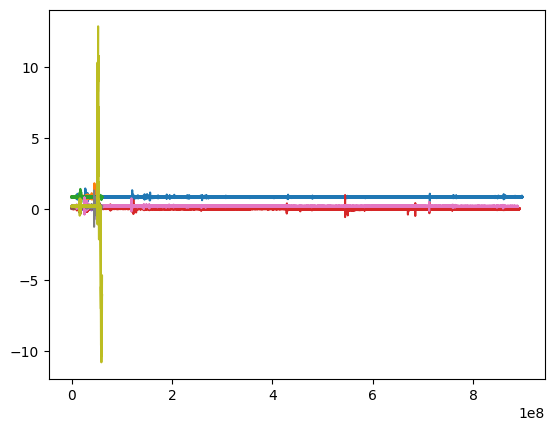

In [47]:
for phone in datas.keys():
    for name in datas[phone]['d'].keys():
        t =  np.asarray(datas[phone]['d'][name]['ta'])
        ax =  np.asarray(datas[phone]['d'][name]['ax'])
        plt.plot(t-t[0],ax)
        print(np.nanmean(ax))

In [36]:


import time
name = 'experiment'
port = 8080

secondes = 60
urllib.request.urlopen(f"http://{ip}:{port}/start?name={name}").read()
t0 = time.time()
for i in range(secondes):
    status = urllib.request.urlopen(f"http://{ip}:{port}/status").read()
    print(i,status)
    time.sleep(1)
urllib.request.urlopen(f"http://{ip}:{port}/stop").read()

status = urllib.request.urlopen(f"http://{ip}:{port}/status").read()
print(i,status)

b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'


b'Finished'

In [77]:
# Poor-man sync. when the accelerometer (in x / directions) will pass the threshold, each phone will take that point in time as its origin
phonelist = [33,34,35]
for phone in phonelist:
    print(phone)
    urllib.request.urlopen(f"http://192.168.{network}.1{phone}:{port}/kick-sync").read()
    
for phone in phonelist:
    print(phone)
    s = urllib.request.urlopen(f"http://192.168.{network}.1{phone}:{port}/kick-time").read()

    print(s)

33
34
35
33
b'58708840485345'
34
b'337839219797248'
35
b'337850561892924'


In [ ]:
for phone in phonelist:
    print(phone)
    urllib.request.urlopen(f"http://192.168.{network}.1{phone}:{port}/kick-sync").read()


In [122]:
# run test recordings of 1 minute
name = 'experiment'
for phone in phonelist:
    print(phone)
    ip = f'192.168.{network}.1{phone}'
# Start recording. name is just for naming the files. Not mandatory
    s = urllib.request.urlopen(f"http://{ip}:{port}/start?name={name}").read()
    print(s)
time.sleep(60)

for phone in phonelist:
    print(phone)
    ip = f'192.168.{network}.1{phone}'
# Start recording. name is just for naming the files. Not mandatory
    s = urllib.request.urlopen(f"http://{ip}:{port}/stop").read()
    print(s)

33
b'Recording experiment experiment-2024-11-26T08_35_17, please stop me'
34
b'Recording experiment experiment-2024-11-26T08_35_20, please stop me'
35
b'Recording experiment experiment-2024-11-26T08_35_20, please stop me'
33
b'Finished'
34
b'Finished'
35
b'Finished'


In [144]:
import re
import urllib
files = {}
#t = '08_23_' ##good !

phonelist=[0,1,3,4,5]
port = 8080
import phonefleet.connect as connect

for phone in phonelist:
    print(phone)
    ip = connect.get_adress(phone)
    
    a = urllib.request.urlopen(f"http://{ip}:{port}/list-files").read()
    s = a.decode('utf-8')
    filelist = s[1:-1].split(', ')

    #rx = re.compile(f'experiment-2024-11-26T{t}*')
    #filelist = list(filter(rx.search, filelist)) 
    pprint(f"Phone {phone}, number of files : {len(filelist)}")
    files[phone]=filelist


0
'Phone 0, number of files : 9236'
1
'Phone 1, number of files : 9168'
3
'Phone 3, number of files : 9008'
4
'Phone 4, number of files : 8356'
5
'Phone 5, number of files : 8984'


In [155]:
import re
import urllib
files = {}
#t = '08_23_' ##good !

phonelist=[0,1,3,4,5]
port = 8080
import phonefleet.connect as connect

for phone in phonelist:
    print(phone)
    ip = connect.get_adress(phone)
    
    a = urllib.request.urlopen(f"http://{ip}:{port}/list-files").read()
    s = a.decode('utf-8')
    filelist = s[1:-1].split(', ')

    #rx = re.compile(f'experiment-2024-11-26T{t}*')
    #filelist = list(filter(rx.search, filelist)) 
    pprint(f"Phone {phone}, number of files : {len(filelist)}")
    files[phone]=filelist


0
'Phone 0, number of files : 9236'
1
'Phone 1, number of files : 1'
3
'Phone 3, number of files : 9008'
4
'Phone 4, number of files : 1'
5
'Phone 5, number of files : 1'


In [124]:
data = {}
for phone in files.keys():
    print(phone)
    ip = f'192.168.{network}.1{phone}'
    filelist = files[phone]
    data[phone]={}
    for filename in filelist:
        print(filename)
        parse = filename.split('.')
        if len(parse)>2:
            v = parse[-2][0]
            print(v)
        else:
            v = 'loc'
        d = urllib.request.urlopen(f"http://{ip}:{port}/get-file/"+filename).read()
        name = filename.split('.')[-2]
        data[phone].update(decode_data(d,v=v))
        print(np.max(data[phone]['ta']))

33
experiment-2024-11-26T08_35_17-android.sensor.accelerometer-0--1--1.csv
a
(360000, 4)
-1.0
experiment-2024-11-26T08_35_17-android.sensor.gyroscope-0--1--1.csv
g
(360000, 4)
-1.0
experiment-2024-11-26T08_35_17-android.sensor.magnetic_field-0--1--1.csv
m
(45000, 4)
-1.0
experiment-2024-11-26T08_35_17-gps-0--1--1.csv
(900, 4)
-1.0
34
experiment-2024-11-26T08_35_20-android.sensor.accelerometer-0--1--1.csv
a
(360000, 4)
-1.0
experiment-2024-11-26T08_35_20-android.sensor.gyroscope-0--1--1.csv
g
(360000, 4)
-1.0
experiment-2024-11-26T08_35_20-android.sensor.magnetic_field-0--1--1.csv
m
(45000, 4)
-1.0
experiment-2024-11-26T08_35_20-gps-0--1--1.csv
(900, 4)
-1.0
35
experiment-2024-11-26T08_35_20-android.sensor.accelerometer-0--1--1.csv
a
(360000, 4)
-1.0
experiment-2024-11-26T08_35_20-android.sensor.gyroscope-0--1--1.csv
g
(360000, 4)
-1.0
experiment-2024-11-26T08_35_20-android.sensor.magnetic_field-0--1--1.csv
m
(45000, 4)
-1.0
experiment-2024-11-26T08_35_20-gps-0--1--1.csv
(900, 4)
-1.0


88.005978
82.424089
75.974002


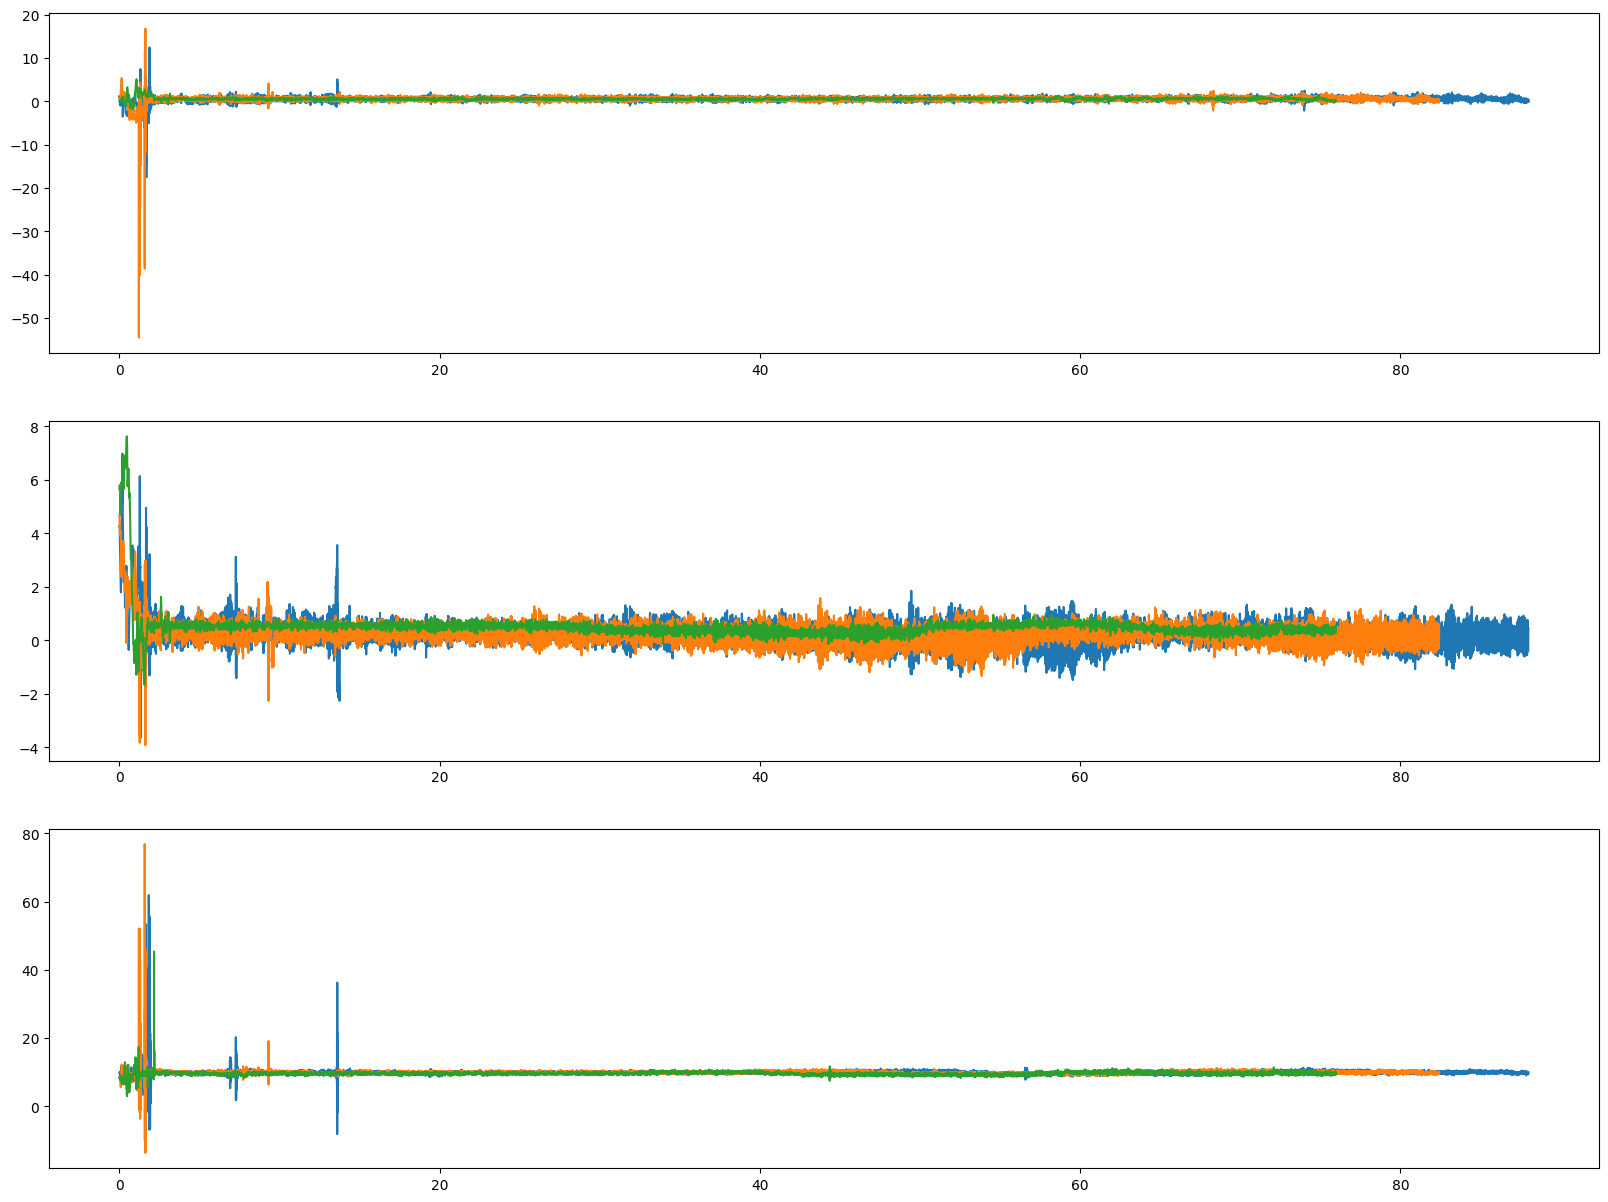

In [119]:
fig,axs = plt.subplots(figsize=(20,15),nrows=3)
coords = ['x','y','z']
for phone in phonelist:
#    print(data[phone].keys())   
    for coord,ax in zip(coords,axs):
        t0 = data[phone]['ta'][0]
        t = (data[phone]['ta']-t0)/10**6
        y = data[phone]['a'+coord]
        ax.plot(t,y)
    print(np.max(t))

In [ ]:
# get the data from the last recording


In [40]:
port = 8080
name = 'experiment'
for phone in phonelist[12:]:
    print(phone)
    ip = f'192.168.2.1{phone}'
# Start recording. name is just for naming the files. Not mandatory
#    urllib.request.urlopen(f"http://{ip}:{port}/start?name={name}").read()
    urllib.request.urlopen(f"http://{ip}:{port}/stop").read()

47
48
49


In [42]:
# get the data
import subprocess

filelist = {}
for phone in phonelist:
    print(phone)
    ip = f'192.168.2.1{phone}'
    files = subprocess.run(['adb','-s',ip, 'shell','ls','storage/self/primary/Download/SensorDumper/*21_*accelero*.csv'],text=True,capture_output = True)#,stdout=True,stderr=True)
    lines = str(files).split("stdout='")[1].split('\\n')
    print(lines[:-1])
    filelist[phone]=lines[:-1]

#adb -s 192.168.2.133 push ~/Documents/Telephones/2024_Jules_Caso/app-release.apk /storage/self/primary/Download/app_JC_20112024.pak

33
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_51-android.sensor.accelerometer-3--1--1.csv']
34
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_52-android.sensor.accelerometer-4--1--1.csv']
35
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_54-android.sensor.accelerometer-2--1--1.csv']
36
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_56-android.sensor.accelerometer-2--1--1.csv']
37
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_57-android.sensor.accelerometer-2--1--1.csv']
38
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_58-android.sensor.accelerometer-2--1--1.csv', 'storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_58-android.sensor.accelerometer-2-73530737--1.csv']
39
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_58-android.sensor.accelerometer-2--1--1.csv']
42
['storage/self/prim

In [45]:
folder = "test_round_table/Run2/"
for phone in filelist.keys():
    print(phone)
    if phone==46:
        ip = f'192.168.2.1{phone}'
        for filename in filelist[phone]:
            #print(filename)
            savefile = folder+f"{phone}_"+filename.split('/')[-1]
            print(savefile)
            subprocess.run(['adb','-s',ip, 'pull',filename,savefile],text=True,stdout=True,)

33
34
35
36
37
38
39
42
43
44
45
46
test_round_table/Run2/46_', stderr='adb: device offline
adb: error: failed to stat remote object '', stderr='adb: device offline': No such file or directory
47
48
49


In [46]:
filelist = glob.glob(folder+'*.csv')

data = {}
for filename in filelist:
    phone = int(filename.split('/')[-1][:2])
    print(phone)
    d = rw_data.read_csv(filename)
    if phone in data.keys():
        data[phone]=data[phone]+d
    else:
        data[phone]=d

33
34
35
36
37
38
38
39
42
43
44
44
45
45
47
47
48
49


In [51]:
data[33][0]

['-1', ' NaN', ' NaN', ' NaN', ' ']

33
33 0.0
34
34 0.0
35
35 0.0
36
36 0.0
37
37 0.0
38
38 8303.7256606305
39
39 0.0
42
42 0.0
43
43 0.0
44
44 1673.1497131303
45
45 632.8303770079999
47
47 6281.1104444935
48
48 0.0
49
49 0.0


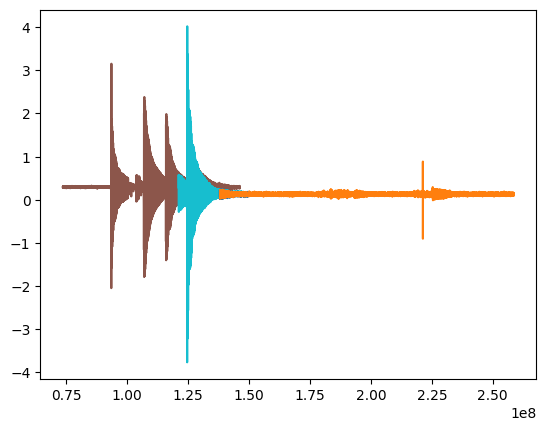

In [58]:

for phone in data.keys():
    print(phone)
    N = len(data[phone])
    a = np.zeros(N)
    t = np.zeros(N)
    for i in range(N):
        a[i] = data[phone][i][1]
        t[i] = data[phone][i][0]

    print(phone,np.nansum(a))
    plt.plot(t,a)
#plt.xlim([3.5*10**8,6*10**8])

In [68]:
phone = 44
N = len(data[phone])
print(N)
a = []
t = []
for i in range(N):
    if float(data[phone][i][0])>0:
        a.append(float(data[phone][i][1]))
        t.append(float(data[phone][i][0]))
print(len(t))
#plt.plot(t,a)

720000
11258


(0.0, 5000.0)

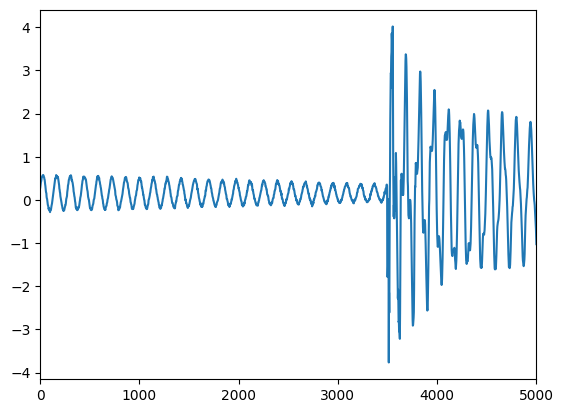

In [75]:
t = np.asarray(t)
a = np.asarray(a)
plt.plot((t-t[0])/1000,a)
plt.xlim([0,5*10**3])

In [ ]:
filelist = subprocess.run(['adb','devices'],text=True,stdout=True)

In [ ]:
name = 'experiment-2024-11-21T17_53_17-android.sensor.gyroscope-1-7082360130--1.csv'
savefile = "/Users/stephane/Documents/Telephones/2024_Jules_Caso/gyroscope.csv"
filelist = subprocess.run(['adb','-s',ip, 'pull',f"storage/self/primary/Download/SensorDumper/{name}",savefile],text=True,stdout=True,)

In [ ]:
import icewave.tools.rw_data as rw_data

filename = "/Users/stephane/Documents/Telephones/2024_Jules_Caso/gyroscope.csv"
data = rw_data.read_csv(filename)

In [ ]:
data = np.asarray(data)
plt.plot(data[:100,1].astype(float))

In [ ]:
a = plt.hist(np.diff(data[:10000,0].astype(int))/1000,100)
np.mean(np.diff(data[:10000,0].astype(int))/1000)

In [ ]:
np.mean(np.diff(np.asarray(data)[0,:10000].astype(int)))

In [ ]:
data = np.asarray(data)
data.shape

In [ ]:
data[0,:]

In [ ]:
t = data[:,0].astype(int)
acx = data[:,1].astype(float)
acy = data[:,2].astype(float)
acz = data[:,3].astype(float)

fig,ax = plt.subplots(figsize=(20,5))
ax.plot((t-t[0])/1000000,acz)
plt.xlim([0,1200])
g = 9.81
plt.ylim([-0.2+g,0.2+g])